<a href="https://colab.research.google.com/github/rafaelguibson/ueg_tcc/blob/main/TC_II_An%C3%A1lise_de_Dados_de_Opera%C3%A7%C3%B5es_Agricolas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importação de Bibliotecas

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from google.colab import drive

###Carregamento do diretorio do Drive

In [ ]:
# ============= Bloco usado somente para execução com arquivo no GDrive =================
# drive.mount('/content/drive')

# data_path = '/content/drive/MyDrive/TCC/DADOS-PROF-AGRICOLA/PULVERIZAÇÃO/Dados completos/'

# if not os.path.exists(data_path):
#     os.makedirs(data_path)
# os.chdir(data_path)
# print('Diretório Usado: ',os.getcwd())
# ========================================================================================

Mounted at /content/drive
Diretório Usado:  /content/drive/MyDrive/TCC/DADOS-PROF-AGRICOLA/PULVERIZAÇÃO/Dados completos


###Leitura do arquivo

In [ ]:
df = pd.read_csv('dados_completos_2022_2023.csv', sep=';', on_bad_lines='skip', low_memory=False)

In [ ]:
print(df.dtypes)

###Tratamento de valores \*NÃO_DEFINIDO\*

Será trocado em todas as colunas que possuem o valor \*NAO_DEFINIDO\* por 0.

In [ ]:
# === BLOCO: Trocar Valores *NAO_DEFINIDO* por 0 ===
df.replace('*NAO_DEFINIDO*', 0, inplace=True)

###Remoção de Colunas Irrelevantes à análise

Foram removidas as colunas <code>'vl_rendimento_colheita'</code> , <code>'vl_umidade_graos'</code> , <code>'vl_qtde_sementes_ha_total'</code> ,  <code>'vl_taxa_aplicacao_solido_ha'</code> pois elas contém apenas valores zero e não serão relevante no caso de operações de pulverização.


In [ ]:
colunas_remover = [
    'vl_rendimento_colheita',
    'vl_umidade_graos',
    'vl_qtde_sementes_ha_total',
    'vl_taxa_aplicacao_solido_ha'
]

# Remover as colunas do DataFrame
df.drop(columns=colunas_remover, inplace=True)

# Confirmar se as colunas foram removidas
# df.info()

###Tratamento de coordenadas
Foi identificado que as coordenadas era lidos sem a formatação correta do padrão de latitude e longitude correspondentes a realização da operação de pulverização, além de alguns valores minimos e maximos das colunas sendo 0, o que indica uma possivel falha na leitura das coordenadas naquele dado momento.
Optei por normalizar o formado das coordenadas de acordo com o padrão:
  - Latitude: <code>-17.x</code>
  - Longitude: <code>-51.x </code>

Que são as coordenadas corretas correspondentes a região da fazenda em Goiás.

In [ ]:
import re

def fix_coord(valor, deg_digits=2):
    """
    Converte strings de coordenadas no formato '−1750.192.996' para float '−17.50192996'
    impondo exatamente 'deg_digits' dígitos para os graus (Brasil: 2).
    Regras:
      - preserva o sinal
      - remove tudo que não for dígito ou sinal
      - junta todos os blocos decimais
      - monta: graus = primeiros 'deg_digits' dígitos; fração = resto
      - se já vier como float válido (|valor|<100 e apenas um '.'), retorna direto
    """
    if pd.isna(valor):
        return np.nan

    # já é número?
    if isinstance(valor, (int, float)):
        val = float(valor)
        # se parece grau válido (<100 abs), devolve
        if abs(val) < 100:
            return val
        # caso contrário, continua para tentar reconstruir
        valor = str(valor)

    s = str(valor).strip()

    # troca vírgula por ponto só para detectar formato já válido
    s_norm = s.replace(',', '.')
    # se é um float “normal” e dentro de faixa de graus, aceita
    try:
        v = float(s_norm)
        if abs(v) < 100:
            return v
    except:
        pass

    # extrai sinal
    sign = -1.0 if s.startswith('-') else 1.0

    # remove tudo que não for dígito
    digits = re.sub(r'[^0-9]', '', s)
    if digits == '':
        return np.nan

    # garante comprimento mínimo (graus + pelo menos 1 dígito de fração)
    if len(digits) <= deg_digits:
        # ex.: '17' -> 17.0
        graus = int(digits)
        return sign * float(graus)

    graus = int(digits[:deg_digits])
    frac_str = digits[deg_digits:]
    frac = int(frac_str) / (10 ** len(frac_str))
    return sign * (graus + frac)

# Colunas de coordenadas (tratadas individualmente; Brasil: 2 dígitos para graus)
lat_cols = ['vl_latitude_inicial', 'vl_latitude_final', 'latitude_interpolacao']
lon_cols = ['vl_longitude_inicial', 'vl_longitude_final', 'longitude_interpolacao']

for c in lat_cols:
    df[c] = df[c].apply(lambda x: fix_coord(x, deg_digits=2))

for c in lon_cols:
    df[c] = df[c].apply(lambda x: fix_coord(x, deg_digits=2))

# Verificação rápida: faixas por coluna (esperado Goiás ~ lat ~ -16 a -18; lon ~ -48 a -52)
print(df[lat_cols + lon_cols].agg(['min','max']).T)
print(df[lat_cols + lon_cols].head())


                              min  max
vl_latitude_inicial    -18.760560  0.0
vl_latitude_final      -18.760560  0.0
latitude_interpolacao  -18.760560  0.0
vl_longitude_inicial   -52.168808  0.0
vl_longitude_final     -52.168808  0.0
longitude_interpolacao -52.168808  0.0
   vl_latitude_inicial  vl_latitude_final  latitude_interpolacao  \
0           -17.501930         -17.501930             -17.501930   
1           -17.501908         -17.501908             -17.501908   
2           -17.501945         -17.501945             -17.501945   
3           -17.501908         -17.501908             -17.501908   
4           -17.501914         -17.501914             -17.501914   

   vl_longitude_inicial  vl_longitude_final  longitude_interpolacao  
0            -51.278088          -51.278088              -51.278088  
1            -51.278121          -51.278121              -51.278121  
2            -51.278053          -51.278053              -51.278053  
3            -51.278088          -51.2

Para os valores minimos e maximos com zero foi usado o método <strong>valor anterior mais próximo (ffill, forward fill).</strong>
Esse método mantém a continuidade espacial real — ou seja, quando há perda de sinal, a posição é “mantida” até o próximo ponto válido, sem inventar médias artificiais.

In [ ]:
# === BLOCO ÚNICO: verificação dos valores vizinhos (min+1 e max-1) ===

cols_coord = [
    'vl_latitude_inicial', 'vl_longitude_inicial',
    'vl_latitude_final', 'vl_longitude_final',
    'latitude_interpolacao', 'longitude_interpolacao'
]

for col in cols_coord:
    print(f"\nColuna: {col}")
    # Encontrar índices do valor mínimo e máximo
    idx_min = df[col].idxmin()
    idx_max = df[col].idxmax()

    # Mostrar o valor mínimo, o próximo (min+1) e o anterior (max-1)
    print("  → Valor mínimo e vizinho:")
    print(df.loc[idx_min:idx_min+1, [col, 'ano']])
    print("  → Valor máximo e vizinho anterior:")
    print(df.loc[idx_max-1:idx_max, [col, 'ano']])



Coluna: vl_latitude_inicial
  → Valor mínimo e vizinho:
       vl_latitude_inicial   ano
16205           -18.760560  2022
16206           -18.760538  2022
  → Valor máximo e vizinho anterior:
       vl_latitude_inicial   ano
76203           -17.530701  2022
76204             0.000000  2022

Coluna: vl_longitude_inicial
  → Valor mínimo e vizinho:
       vl_longitude_inicial   ano
63177            -52.168808  2022
63178            -52.168785  2022
  → Valor máximo e vizinho anterior:
       vl_longitude_inicial   ano
76203            -51.468122  2022
76204              0.000000  2022

Coluna: vl_latitude_final
  → Valor mínimo e vizinho:
       vl_latitude_final   ano
16204         -18.760560  2022
16205         -18.760538  2022
  → Valor máximo e vizinho anterior:
       vl_latitude_final   ano
76203         -17.530748  2022
76204           0.000000  2022

Coluna: vl_longitude_final
  → Valor mínimo e vizinho:
       vl_longitude_final   ano
63178          -52.168808  2022
63179      

###Tratamento da Coluna Data Hora

In [ ]:
# === BLOCO ÚNICO: Consistência temporal, normalizando na própria coluna ===
import pandas as pd

# 1) Converter diretamente a coluna original para datetime
df['dt_hr_local_inicial'] = pd.to_datetime(df['dt_hr_local_inicial'], errors='coerce', dayfirst=True)

# 2) Relatório de integridade temporal
total = len(df)
invalid = df['dt_hr_local_inicial'].isna().sum()
print(f"Total de linhas: {total}")
print(f"Datas inválidas (NaT): {invalid}  ({invalid/total:.2%})")
print("Intervalo temporal (min → max):",
      df['dt_hr_local_inicial'].min(), "→", df['dt_hr_local_inicial'].max())

# 3) Retrocesso e duplicatas por equipamento
df_sorted = df.sort_values(['cd_equipamento', 'dt_hr_local_inicial'], kind='mergesort').copy()
df_sorted['delta_s'] = df_sorted.groupby('cd_equipamento')['dt_hr_local_inicial'].diff().dt.total_seconds()

mask_retro = df_sorted['delta_s'] < 0
mask_dup = df_sorted.duplicated(subset=['cd_equipamento','dt_hr_local_inicial'], keep=False)

print(f"\nRegistros com retrocesso temporal: {int(mask_retro.sum())}")
print(f"Registros com timestamp duplicado por equipamento: {int(mask_dup.sum())}")

# Amostras (se houver)
if mask_retro.any():
    print("\nAmostra de retrocessos:")
    amostra_retro = df_sorted.loc[mask_retro, ['cd_equipamento','dt_hr_local_inicial','delta_s']].head(10)
    print(amostra_retro)

if mask_dup.any():
    print("\nAmostra de duplicatas:")
    print(df_sorted.loc[mask_dup, ['cd_equipamento','dt_hr_local_inicial']].head(10))


Total de linhas: 372039
Datas inválidas (NaT): 0  (0.00%)
Intervalo temporal (min → max): 2022-10-27 00:19:00 → 2023-11-27 22:14:00

Registros com retrocesso temporal: 0
Registros com timestamp duplicado por equipamento: 366136

Amostra de duplicatas:
       cd_equipamento dt_hr_local_inicial
52525            1007 2022-11-08 16:38:00
52526            1007 2022-11-08 16:38:00
52524            1007 2022-11-08 16:39:00
52529            1007 2022-11-08 16:39:00
52520            1007 2022-11-08 16:40:00
52523            1007 2022-11-08 16:40:00
52513            1007 2022-11-08 16:44:00
52514            1007 2022-11-08 16:44:00
52516            1007 2022-11-08 16:44:00
52517            1007 2022-11-08 16:44:00


In [ ]:
# === BLOCO ÚNICO: Nível de redundância (leituras por equipamento por segundo) ===
import pandas as pd

# Garantir que a coluna de tempo está em datetime
df['dt_hr_local_inicial'] = pd.to_datetime(df['dt_hr_local_inicial'], errors='coerce', dayfirst=True)

# Colapsa o timestamp para resolução de 1 segundo
dt_sec = df['dt_hr_local_inicial'].dt.floor('S')

# Conta leituras por (equipamento, segundo)
g = (
    df.groupby(['cd_equipamento', dt_sec])
      .size()
      .rename('n_por_segundo')
      .reset_index()
      .rename(columns={'dt_hr_local_inicial':'ts_seg'})
)

# Estatística geral: quantas linhas por segundo (todas as máquinas)
print("=== Estatísticas gerais (leituras por segundo) ===")
print(g['n_por_segundo'].describe().to_string())

# Estatística por equipamento (útil para ver quem mais repete por segundo)
por_eq = (
    g.groupby('cd_equipamento')['n_por_segundo']
     .describe()[['count','mean','50%','max']]
     .rename(columns={'50%':'median'})
     .sort_values('mean', ascending=False)
)

print("\n=== Top 10 equipamentos com maior média de leituras/segundo ===")
print(por_eq.head(10).to_string())

# Amostra de segundos com alta redundância (n_por_segundo > 1)
amostra = g[g['n_por_segundo'] > 1].sort_values('n_por_segundo', ascending=False).head(10)
print("\n=== Amostra de segundos com maior número de leituras ===")
print(amostra.to_string(index=False))


=== Estatísticas gerais (leituras por segundo) ===
count    48021.000000
mean         7.747423
std          5.605004
min          1.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         44.000000

=== Top 10 equipamentos com maior média de leituras/segundo ===
                  count      mean  median   max
cd_equipamento                                 
3007              295.0  9.603390     9.0  31.0
3005            14796.0  8.593877     8.0  44.0
3004             3779.0  8.302461     8.0  38.0
3003             6426.0  8.026144     7.0  38.0
3008             8432.0  7.605076     7.0  35.0
3002            12428.0  7.293853     6.0  33.0
1009                8.0  5.375000     5.0  11.0
1010              105.0  3.123810     1.0  12.0
1014              235.0  2.663830     1.0  12.0
1012             1070.0  2.467290     1.0  10.0

=== Amostra de segundos com maior número de leituras ===
 cd_equipamento              ts_seg  n_por_segundo
           3005 2023-11

/tmp/ipython-input-2695750889.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dt_sec = df['dt_hr_local_inicial'].dt.floor('S')


###Agrupamento Temporal

A análise mostra o seguinte panorama claro:

- <strong>Média geral:</strong> ~7,7 leituras por segundo.

- <strong>Mediana:</strong> 7 leituras/s — consistente com a média, indicando padrão estável.

- <strong>Picos:</strong> até 44 leituras por segundo em alguns equipamentos.

- <strong>Equipamentos com maior densidade:</strong> os códigos 3005, 3004, 3003 e 3007 lideram, todos na faixa de 8 a 10 leituras/s.

Esses dados indicam que cada máquina registra várias medições simultâneas no mesmo segundo (sensores distintos transmitindo dados contínuos). Isso significa que a granularidade por segundo ainda é detalhada demais para análise de padrões operacionais.


Nara este contexto (comparar COE/COC por ano, analisar tempos por atividade e manter eventos rápidos), a melhor granularidade agora é consolidar por 1 segundo por equipamento. isso elimina as múltiplas leituras simultâneas do mesmo instante (7–10+/s), sem perder resolução temporal.

In [ ]:
# === PATCH ÚNICO: corrigir dtypes + refazer consolidação 1s ===
import pandas as pd
import numpy as np

# 0) garantir datetime e usar 's' (minúsculo) no floor
df['dt_hr_local_inicial'] = pd.to_datetime(df['dt_hr_local_inicial'], errors='coerce', dayfirst=True)
df['_ts_1s'] = df['dt_hr_local_inicial'].dt.floor('s')  # 'S' deprecado → 's'

# 1) definir colunas por tipo de agregação (mesmas do bloco anterior)
cont_vars = [
    'vl_velocidade','vl_rpm','vl_temperatura_motor','vl_consumo_instantaneo',
    'vl_vazao_litros_ha','vl_vazao_litros_min','vl_pressao_bomba (kPa)',
    'vl_hectares_hora','vl_velocidade_vento','vl_temperatura','vl_umidade','vl_ponto_orvalho'
]
coord_vars = [
    'vl_latitude_inicial','vl_longitude_inicial',
    'vl_latitude_final','vl_longitude_final',
    'latitude_interpolacao','longitude_interpolacao'
]
cat_vars = [
    'cd_estado','desc_parada','desc_operador',
    'cd_operacao','cd_operacao_parada','cd_fazenda','cd_zona','cd_talhao','cd_operador'
]
keep_first = ['ano']

# 2) FORÇAR NUMÉRICO nas colunas que vão por mediana (evita "dtype object" com '0' string)
for c in cont_vars + coord_vars:
    if c in df.columns:
        # troca vírgula por ponto se houver, e força numérico (strings '0' → 0.0)
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', '.'), errors='coerce')

# 3) garantir categóricas como string (evita tentar agregá-las por mediana)
for c in cat_vars:
    if c in df.columns:
        df[c] = df[c].astype(str)

# 4) agregadores
def moda_robusta(s):
    if s.empty:
        return pd.NA
    # empates resolvidos pela ordem de aparição: usa idxmax sobre cumsum da contagem
    vc = s.value_counts(dropna=False)
    return vc.index[0]

agg_dict = {c: 'median' for c in cont_vars + coord_vars if c in df.columns}
agg_dict.update({c: moda_robusta for c in cat_vars if c in df.columns})
agg_dict.update({c: 'first' for c in keep_first if c in df.columns})

# 5) groupby por (equipamento, segundo) com contador de colapsos
grouper = ['cd_equipamento','_ts_1s']
df_1s = (
    df.assign(n_por_segundo=1)
      .groupby(grouper, as_index=False)
      .agg({**agg_dict, 'n_por_segundo':'sum'})
      .rename(columns={'_ts_1s':'dt_1s'})
)

# 6) checagem
# print("Dimensões originais:", df.shape, "→ após 1s:", df_1s.shape)
# print("Resumo n_por_segundo:\n", df_1s['n_por_segundo'].describe())
# print("\nAmostra:\n", df_1s.head(5))


### Cálculo de COE/COC por segundo e comparação anual

In [ ]:
# garantir tipo numérico
df_1s['vl_hectares_hora'] = pd.to_numeric(df_1s['vl_hectares_hora'], errors='coerce')

# --- Cálculos por segundo ---
# COE: capacidade operacional efetiva (ha/s) = ha/h ÷ 3600
# COC: capacidade de campo (m²/s) = (ha/h * 10_000) ÷ 3600
df_1s['COE_ha_s'] = df_1s['vl_hectares_hora'] / 3600
df_1s['COC_m2_s'] = df_1s['vl_hectares_hora'] * (10_000 / 3600)

# --- Estatísticas anuais ---
resumo = (
    df_1s.groupby('ano')[['vl_hectares_hora','COE_ha_s','COC_m2_s']]
         .describe(percentiles=[.25,.5,.75])
         .transpose()
)

print("=== Estatísticas anuais de COE/COC ===")
print(resumo)

# --- Diferença percentual média 2023 vs 2022 ---
media_por_ano = df_1s.groupby('ano')[['COE_ha_s','COC_m2_s']].mean()
if 2022 in media_por_ano.index and 2023 in media_por_ano.index:
    delta = ((media_por_ano.loc[2023] - media_por_ano.loc[2022]) / media_por_ano.loc[2022]) * 100
    print("\nVariação percentual 2023 vs 2022 (%):")
    print(delta)


=== Estatísticas anuais de COE/COC ===
ano                             2022          2023
vl_hectares_hora count  24992.000000  23029.000000
                 mean      23.240657     27.306438
                 std       27.872265     29.739032
                 min        0.000000      0.000000
                 25%        0.000000      0.000000
                 50%        0.000000     11.050000
                 75%       52.160000     54.850000
                 max       96.520000     88.360000
COE_ha_s         count  24992.000000  23029.000000
                 mean       0.006456      0.007585
                 std        0.007742      0.008261
                 min        0.000000      0.000000
                 25%        0.000000      0.000000
                 50%        0.000000      0.003069
                 75%        0.014489      0.015236
                 max        0.026811      0.024544
COC_m2_s         count  24992.000000  23029.000000
                 mean      64.557381     75

### Mapa de Correlações (heatmap)

=== Correlação com COE e COC ===
                        COE_ha_s  COC_m2_s
COE_ha_s                1.000000  1.000000
COC_m2_s                1.000000  1.000000
vl_hectares_hora        1.000000  1.000000
vl_vazao_litros_min     0.958190  0.958190
vl_pressao_bomba (kPa)  0.829510  0.829510
vl_vazao_litros_ha      0.759760  0.759760
vl_consumo_instantaneo  0.449682  0.449682
vl_ponto_orvalho        0.443200  0.443200
vl_rpm                  0.326571  0.326571
vl_umidade              0.303549  0.303549
vl_temperatura          0.282501  0.282501
vl_velocidade           0.228360  0.228360
vl_velocidade_vento     0.159720  0.159720
vl_temperatura_motor   -0.071007 -0.071007


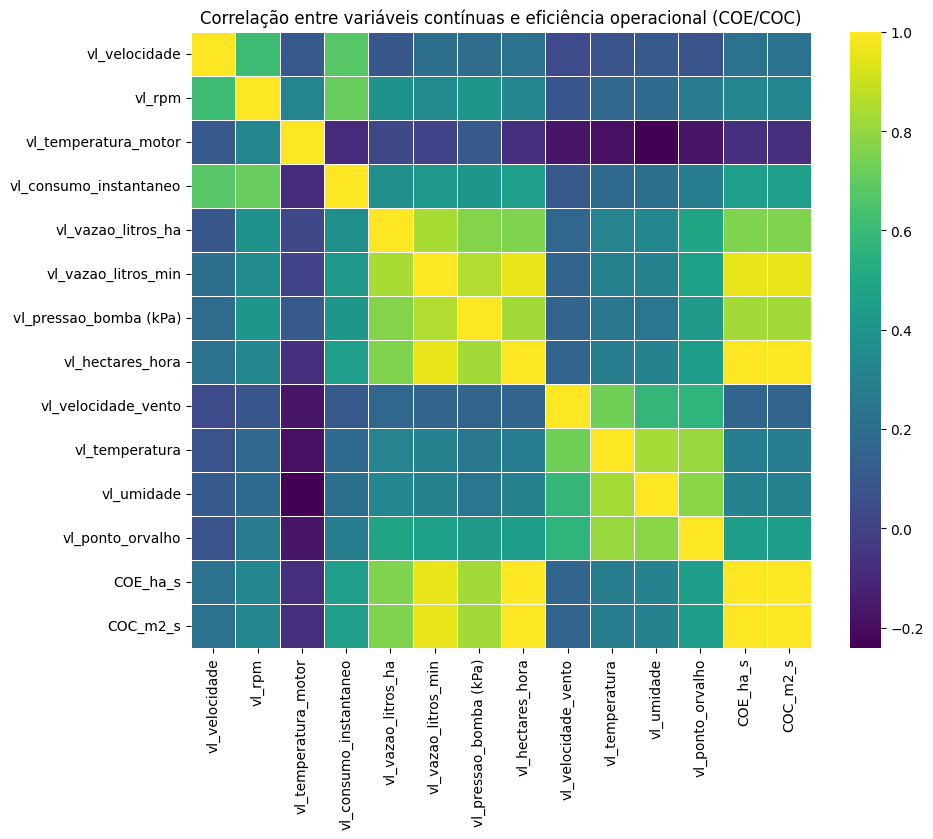

In [ ]:
# === BLOCO ÚNICO: análise de correlação entre variáveis contínuas e COE/COC ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# selecionar apenas as variáveis numéricas relevantes
cont_vars = [
    'vl_velocidade','vl_rpm','vl_temperatura_motor','vl_consumo_instantaneo',
    'vl_vazao_litros_ha','vl_vazao_litros_min','vl_pressao_bomba (kPa)',
    'vl_hectares_hora','vl_velocidade_vento','vl_temperatura','vl_umidade','vl_ponto_orvalho',
    'COE_ha_s','COC_m2_s'
]

# garantir que todas estejam numéricas
df_1s_corr = df_1s[cont_vars].apply(pd.to_numeric, errors='coerce')

# calcular matriz de correlação (Pearson)
corr = df_1s_corr.corr(method='pearson')

# imprimir correlação das variáveis com COE e COC
print("=== Correlação com COE e COC ===")
print(corr[['COE_ha_s','COC_m2_s']].sort_values(by='COE_ha_s', ascending=False))

# --- visualização opcional ---
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='viridis', annot=False, linewidths=0.5)
plt.title('Correlação entre variáveis contínuas e eficiência operacional (COE/COC)')
plt.show()


##Modelos de Predição

###Modelo de Regressão Linear para COE

In [ ]:
# === BLOCO ÚNICO: Regressão Linear para prever COE_ha_s ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# --- 1. Seleção de variáveis explicativas e alvo ---
features = [
    'vl_vazao_litros_min',
    'vl_pressao_bomba (kPa)',
    'vl_vazao_litros_ha',
    'vl_rpm',
    'vl_velocidade',
    'vl_consumo_instantaneo',
    'vl_ponto_orvalho',
    'vl_umidade',
    'vl_temperatura_motor'
]

target = 'COE_ha_s'

# Garantir que todos os dados estão numéricos e sem NaN
df_model = df_1s[features + [target]].copy()
df_model = df_model.apply(pd.to_numeric, errors='coerce').dropna()

# --- 2. Dividir treino e teste ---
X_train, X_test, y_train, y_test = train_test_split(
    df_model[features], df_model[target],
    test_size=0.25, random_state=42
)

# --- 3. Treinar modelo linear simples ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- 4. Avaliar modelo ---
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=== Desempenho do Modelo de Regressão Linear ===")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print("\nCoeficientes (influência das variáveis sobre COE):")

coef_table = pd.DataFrame({
    'Variável': features,
    'Coeficiente': model.coef_,
}).sort_values(by='Coeficiente', ascending=False)
print(coef_table.to_string(index=False))

# --- 5. (Opcional) Mostrar previsão vs. real ---
amostra = pd.DataFrame({'Real': y_test[:10], 'Previsto': y_pred[:10]})
print("\nAmostra de previsões:")
print(amostra)


=== Desempenho do Modelo de Regressão Linear ===
R²: 0.9346
MAE: 0.001281
RMSE: 0.002051

Coeficientes (influência das variáveis sobre COE):
              Variável   Coeficiente
   vl_vazao_litros_min  2.721850e-04
vl_consumo_instantaneo  6.283274e-05
vl_pressao_bomba (kPa)  4.269112e-06
            vl_umidade  4.413716e-07
                vl_rpm -3.292128e-07
      vl_ponto_orvalho -2.630535e-06
         vl_velocidade -3.577942e-06
  vl_temperatura_motor -1.575774e-05
    vl_vazao_litros_ha -3.673863e-05

Amostra de previsões:
           Real  Previsto
14757  0.016178  0.017213
27595  0.009758  0.016588
28697  0.021235  0.021891
34867  0.000000  0.001569
6268   0.000000 -0.000813
45322  0.011265  0.008293
20330  0.016360  0.016546
16581  0.000000 -0.000630
31925  0.000000  0.000431
43209  0.000000  0.000495


###Random Forest Regressor para previsão do COE

=== Desempenho do Random Forest ===
R²: 0.9800
MAE: 0.000369
RMSE: 0.001134


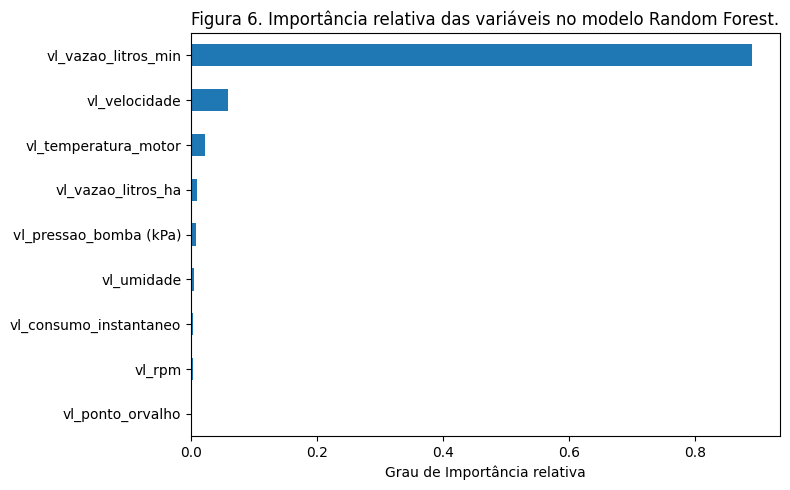


Ranking de importância das variáveis:
vl_vazao_litros_min       0.889870
vl_velocidade             0.059234
vl_temperatura_motor      0.022543
vl_vazao_litros_ha        0.009024
vl_pressao_bomba (kPa)    0.007195
vl_umidade                0.004002
vl_consumo_instantaneo    0.003183
vl_rpm                    0.002920
vl_ponto_orvalho          0.002029
dtype: float64


In [ ]:
# === BLOCO ÚNICO: Modelo não linear (Random Forest) ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Seleção das variáveis explicativas e alvo ---
features = [
    'vl_vazao_litros_min',
    'vl_pressao_bomba (kPa)',
    'vl_vazao_litros_ha',
    'vl_rpm',
    'vl_velocidade',
    'vl_consumo_instantaneo',
    'vl_ponto_orvalho',
    'vl_umidade',
    'vl_temperatura_motor'
]
target = 'COE_ha_s'

# Garantir dados numéricos e limpos
df_model = df_1s[features + [target]].apply(pd.to_numeric, errors='coerce').dropna()

# --- 2. Divisão treino/teste ---
X_train, X_test, y_train, y_test = train_test_split(
    df_model[features], df_model[target],
    test_size=0.25, random_state=42
)

# --- 3. Treinar Random Forest ---
rf = RandomForestRegressor(
    n_estimators=200,       # número de árvores
    max_depth=None,         # permite crescimento total
    random_state=42,
    n_jobs=-1               # usa todos os núcleos disponíveis
)
rf.fit(X_train, y_train)

# --- 4. Avaliação ---
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=== Desempenho do Random Forest ===")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")

# --- 5. Importância das variáveis ---
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(8,5))
importances.plot(kind='barh')
plt.title('Figura 6. Importância relativa das variáveis no modelo Random Forest.')
plt.xlabel('Grau de Importância relativa')
plt.tight_layout()
plt.show()

print("\nRanking de importância das variáveis:")
print(importances.sort_values(ascending=False))


###Mapa de calor espacial (COE médio por célula)

Total de pontos plotados: 48021  |  Ano: todos


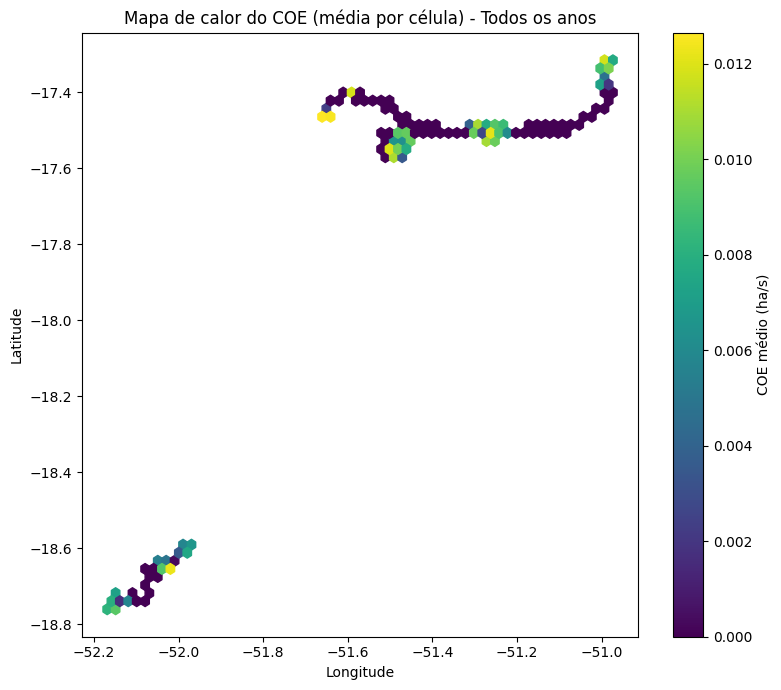

In [ ]:
# === BLOCO ÚNICO: mapa de calor espacial (COE médio por célula) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- 1) Parâmetros rápidos -----
ano_filtro = None        # defina como 2022 ou 2023 para filtrar; deixe None para usar todos
gridsize   = 60          # resolução do hexbin (quanto maior, mais detalhado)
lat_bounds = (-19.5, -15.5)   # faixa ampla que cobre Goiás; ajuste se quiser
lon_bounds = (-53.5, -49.0)

# ----- 2) Preparar dados -----
cols_req = ['latitude_interpolacao','longitude_interpolacao','COE_ha_s','ano']
data = df_1s[cols_req].copy()

# Remover coordenadas ausentes ou inválidas
data = data.dropna(subset=['latitude_interpolacao','longitude_interpolacao','COE_ha_s'])

# Filtrar por ano se definido
if ano_filtro is not None:
    data = data[data['ano'] == ano_filtro]

# Limitar a faixa espacial (evita pontos perdidos)
data = data[
    (data['latitude_interpolacao'].between(lat_bounds[0], lat_bounds[1])) &
    (data['longitude_interpolacao'].between(lon_bounds[0], lon_bounds[1]))
]

print(f"Total de pontos plotados: {len(data)}  |  Ano: {ano_filtro if ano_filtro else 'todos'}")

# ----- 3) Plot: hexbin com média do COE por célula -----
plt.figure(figsize=(8, 7))
hb = plt.hexbin(
    data['longitude_interpolacao'].to_numpy(),
    data['latitude_interpolacao'].to_numpy(),
    C=data['COE_ha_s'].to_numpy(),
    gridsize=gridsize,
    reduce_C_function=np.nanmean,   # média do COE por célula
    mincnt=3                        # só pinta células com >=3 pontos (ruído menor)
)
cb = plt.colorbar(hb)
cb.set_label('COE médio (ha/s)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Mapa de calor do COE (média por célula) - {ano_filtro if ano_filtro else "Todos os anos"}')
plt.tight_layout()
plt.show()


###Comparação Espacial COE × Variável Operacional

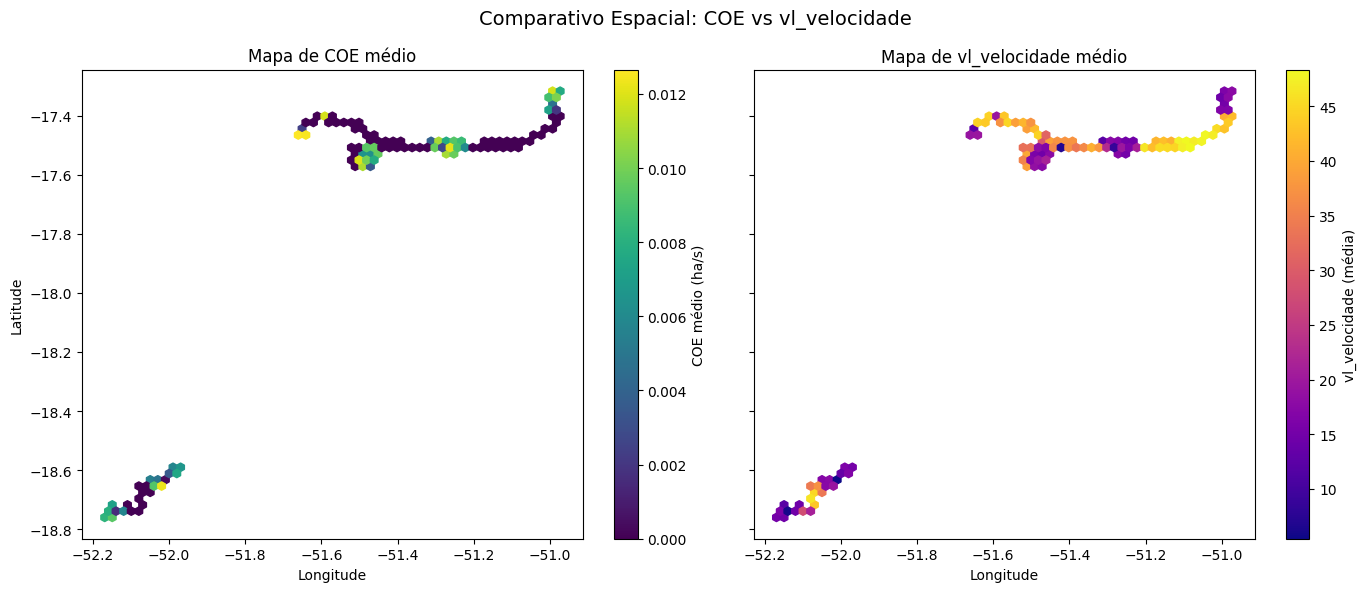

In [ ]:
# === BLOCO ÚNICO: comparação espacial entre COE e uma variável operacional ===
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Escolher variável para comparar com o COE ---
var_comparada = 'vl_velocidade'  # altere para outra variável conforme interesse

# --- 2. Selecionar colunas relevantes ---
cols = ['latitude_interpolacao', 'longitude_interpolacao', 'COE_ha_s', var_comparada]
data = df_1s[cols].dropna()

# --- 3. Limites de área (mantém consistência visual) ---
lat_bounds = (-19.5, -15.5)
lon_bounds = (-53.5, -49.0)

# --- 4. Plotagem lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Mapa 1: COE médio
hb1 = axes[0].hexbin(
    data['longitude_interpolacao'],
    data['latitude_interpolacao'],
    C=data['COE_ha_s'],
    gridsize=60, reduce_C_function=np.nanmean, cmap='viridis', mincnt=3
)
cb1 = fig.colorbar(hb1, ax=axes[0])
cb1.set_label('COE médio (ha/s)')
axes[0].set_title('Mapa de COE médio')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Mapa 2: variável operacional média
hb2 = axes[1].hexbin(
    data['longitude_interpolacao'],
    data['latitude_interpolacao'],
    C=data[var_comparada],
    gridsize=60, reduce_C_function=np.nanmean, cmap='plasma', mincnt=3
)
cb2 = fig.colorbar(hb2, ax=axes[1])
cb2.set_label(f'{var_comparada} (média)')
axes[1].set_title(f'Mapa de {var_comparada} médio')
axes[1].set_xlabel('Longitude')

plt.suptitle(f'Comparativo Espacial: COE vs {var_comparada}', fontsize=14)
plt.tight_layout()
plt.show()

###Comparação Espacial — COE vs vl_vazao_litros_min

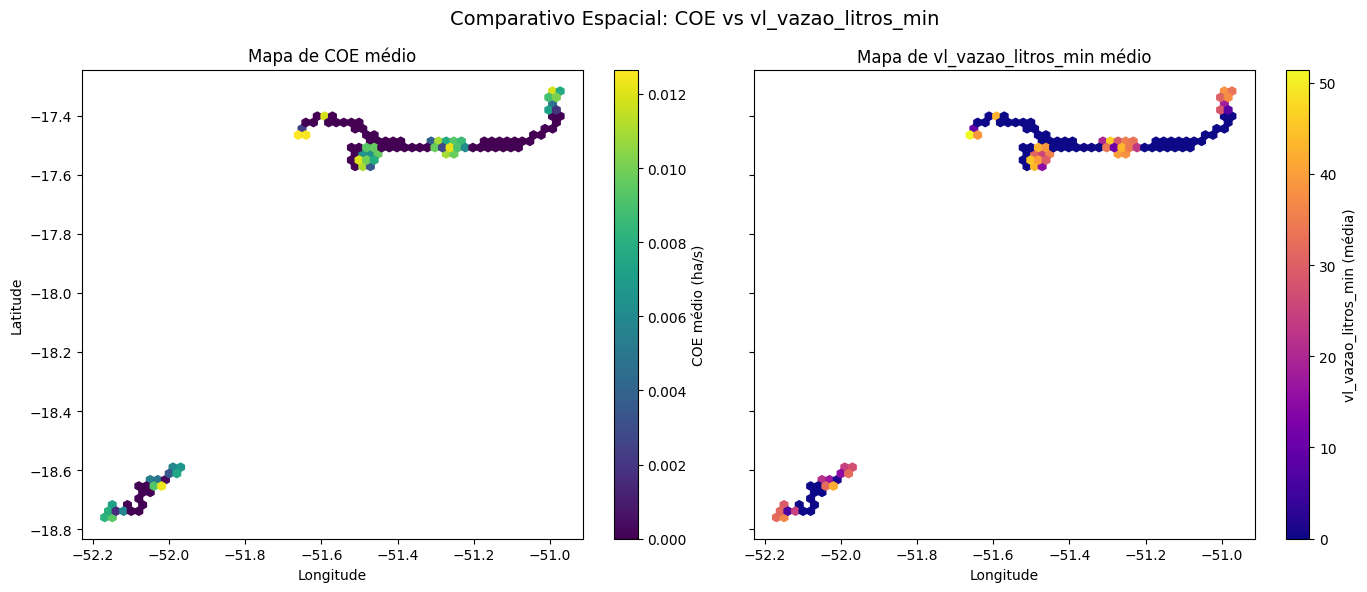

In [ ]:
# === BLOCO ÚNICO: comparação espacial — COE vs vl_vazao_litros_min ===
import numpy as np
import matplotlib.pyplot as plt

var_comparada = 'vl_vazao_litros_min'  # foco hidráulico

# dados mínimos necessários
cols = ['latitude_interpolacao', 'longitude_interpolacao', 'COE_ha_s', var_comparada]
data = df_1s[cols].dropna()

# limites amplos p/ Goiás (ajuste se quiser)
lat_bounds = (-19.5, -15.5)
lon_bounds = (-53.5, -49.0)
data = data[
    (data['latitude_interpolacao'].between(lat_bounds[0], lat_bounds[1])) &
    (data['longitude_interpolacao'].between(lon_bounds[0], lon_bounds[1]))
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# COE médio
hb1 = axes[0].hexbin(
    data['longitude_interpolacao'], data['latitude_interpolacao'],
    C=data['COE_ha_s'], gridsize=60, reduce_C_function=np.nanmean,
    cmap='viridis', mincnt=3
)
cb1 = fig.colorbar(hb1, ax=axes[0]); cb1.set_label('COE médio (ha/s)')
axes[0].set_title('Mapa de COE médio'); axes[0].set_xlabel('Longitude'); axes[0].set_ylabel('Latitude')

# vl_vazao_litros_min média
hb2 = axes[1].hexbin(
    data['longitude_interpolacao'], data['latitude_interpolacao'],
    C=data[var_comparada], gridsize=60, reduce_C_function=np.nanmean,
    cmap='plasma', mincnt=3
)
cb2 = fig.colorbar(hb2, ax=axes[1]); cb2.set_label('vl_vazao_litros_min (média)')
axes[1].set_title('Mapa de vl_vazao_litros_min médio'); axes[1].set_xlabel('Longitude')

plt.suptitle('Comparativo Espacial: COE vs vl_vazao_litros_min', fontsize=14)
plt.tight_layout()
plt.show()

###Variabilidade Espacial da Vazão (CV por célula)

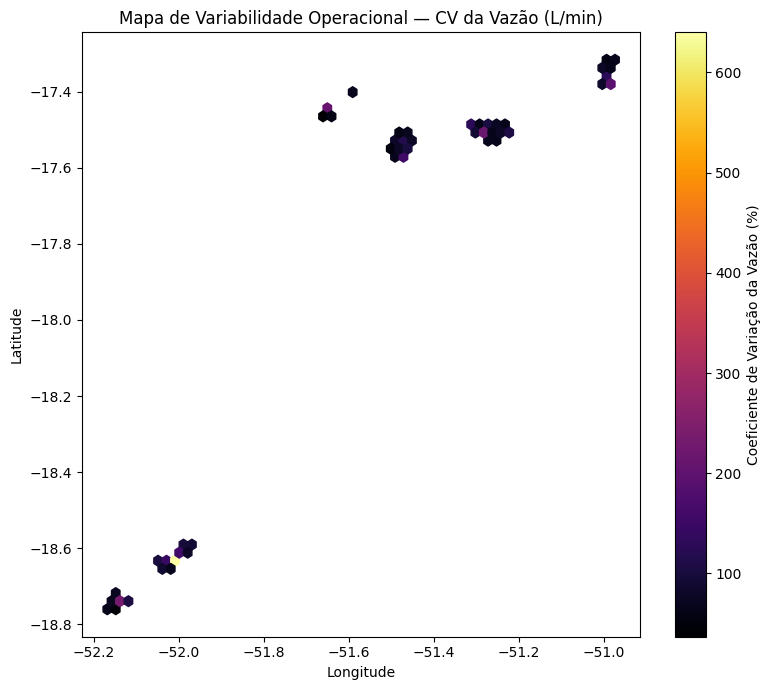

In [ ]:
# === BLOCO ÚNICO: variabilidade espacial (coeficiente de variação da vazão) ===
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Seleção de dados relevantes ---
var_analisada = 'vl_vazao_litros_min'
cols = ['latitude_interpolacao', 'longitude_interpolacao', var_analisada]
data = df_1s[cols].dropna()

# --- 2. Definir grade espacial (hexagonal) e função para cálculo do CV ---
def cv(values):
    """Coeficiente de variação em %"""
    arr = np.array(values)
    if len(arr) == 0 or np.nanmean(arr) == 0:
        return np.nan
    return (np.nanstd(arr) / np.nanmean(arr)) * 100

# --- 3. Parâmetros de mapa ---
lat_bounds = (-19.5, -15.5)
lon_bounds = (-53.5, -49.0)

# --- 4. Plotagem do mapa de variabilidade ---
plt.figure(figsize=(8, 7))
hb = plt.hexbin(
    data['longitude_interpolacao'],
    data['latitude_interpolacao'],
    C=data[var_analisada],
    gridsize=60,
    reduce_C_function=cv,   # aplica coeficiente de variação
    cmap='inferno',
    mincnt=5
)

cb = plt.colorbar(hb)
cb.set_label('Coeficiente de Variação da Vazão (%)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapa de Variabilidade Operacional — CV da Vazão (L/min)')
plt.tight_layout()
plt.show()


###Correlação Espacial entre CV da vazão e COE

Correlação de Pearson entre CV da Vazão e COE médio: -0.6976
Valor-p: 0.000000


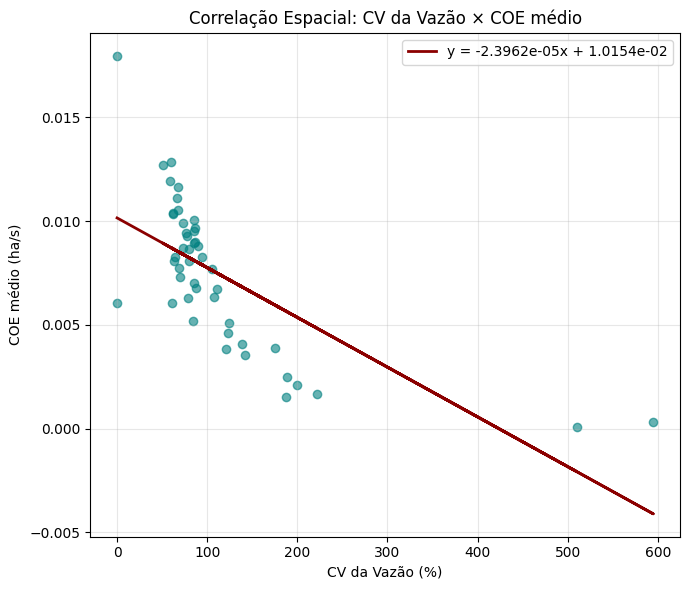

In [ ]:
# === BLOCO ÚNICO: correlação espacial CV_vazão × COE ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- 1. Função para calcular coeficiente de variação ---
def cv(values):
    arr = np.array(values)
    if len(arr) == 0 or np.nanmean(arr) == 0:
        return np.nan
    return (np.nanstd(arr) / np.nanmean(arr)) * 100

# --- 2. Seleção de colunas necessárias ---
cols = ['latitude_interpolacao', 'longitude_interpolacao', 'vl_vazao_litros_min', 'COE_ha_s']
data = df_1s[cols].dropna()

# --- 3. Criar grid espacial para calcular métricas por célula ---
gridsize = 60
x_bins = np.linspace(data['longitude_interpolacao'].min(), data['longitude_interpolacao'].max(), gridsize)
y_bins = np.linspace(data['latitude_interpolacao'].min(), data['latitude_interpolacao'].max(), gridsize)

# --- 4. Agregar dados por célula espacial ---
data['x_bin'] = np.digitize(data['longitude_interpolacao'], x_bins)
data['y_bin'] = np.digitize(data['latitude_interpolacao'], y_bins)

agg = data.groupby(['x_bin', 'y_bin']).agg({
    'vl_vazao_litros_min': lambda x: cv(x),
    'COE_ha_s': 'mean'
}).reset_index()

agg.rename(columns={'vl_vazao_litros_min': 'CV_vazao', 'COE_ha_s': 'COE_medio'}, inplace=True)
agg = agg.dropna()

# --- 5. Calcular correlação entre variabilidade da vazão e eficiência ---
corr, p_value = pearsonr(agg['CV_vazao'], agg['COE_medio'])

print(f"Correlação de Pearson entre CV da Vazão e COE médio: {corr:.4f}")
print(f"Valor-p: {p_value:.6f}")

# --- 6. Gráfico de dispersão ---
plt.figure(figsize=(7, 6))
plt.scatter(agg['CV_vazao'], agg['COE_medio'], alpha=0.6, color='teal')
plt.title('Correlação Espacial: CV da Vazão × COE médio')
plt.xlabel('CV da Vazão (%)')
plt.ylabel('COE médio (ha/s)')
plt.grid(True, alpha=0.3)

# linha de tendência
m, b = np.polyfit(agg['CV_vazao'], agg['COE_medio'], 1)
plt.plot(agg['CV_vazao'], m*agg['CV_vazao'] + b, color='darkred', linewidth=2, label=f'y = {m:.4e}x + {b:.4e}')
plt.legend()
plt.tight_layout()
plt.show()


###Matriz de Correlação Hierárquica

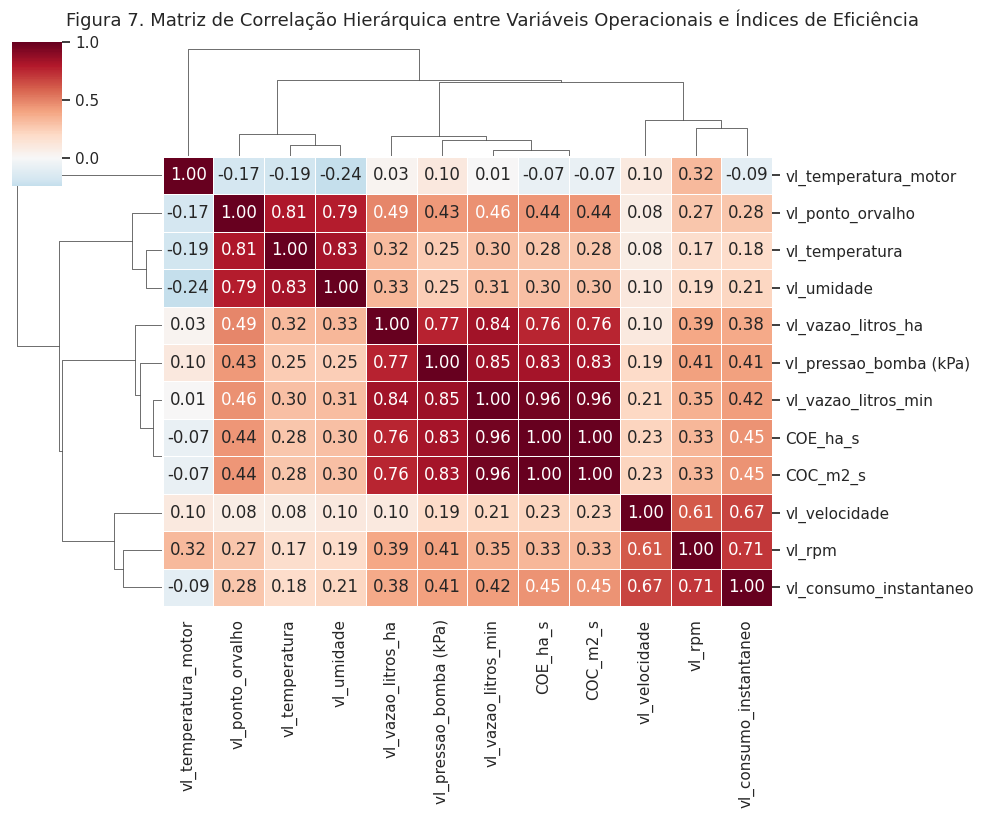

In [ ]:
# === BLOCO ÚNICO: matriz de correlação hierárquica (COE, COC e variáveis operacionais) ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

# --- 1. Seleção das colunas numéricas de interesse ---
vars_corr = [
    'COE_ha_s', 'COC_m2_s',
    'vl_vazao_litros_min', 'vl_vazao_litros_ha', 'vl_pressao_bomba (kPa)',
    'vl_velocidade', 'vl_rpm', 'vl_temperatura_motor',
    'vl_consumo_instantaneo', 'vl_temperatura', 'vl_umidade', 'vl_ponto_orvalho'
]

df_corr = df_1s[vars_corr].apply(pd.to_numeric, errors='coerce').dropna()

# --- 2. Calcular correlação (Pearson) ---
corr = df_corr.corr(method='pearson')

# --- 3. Ordenar hierarquicamente as variáveis (clustering) ---
linkage = hierarchy.linkage(corr, method='average')
sns.set(style='white', font_scale=1.0)

# --- 4. Plotar heatmap com dendrograma hierárquico ---
g = sns.clustermap(
    corr, row_linkage=linkage, col_linkage=linkage,
    cmap='RdBu_r', center=0, linewidths=0.5, annot=True, fmt=".2f",
    figsize=(10, 8)
)

plt.suptitle('Figura 7. Matriz de Correlação Hierárquica entre Variáveis Operacionais e Índices de Eficiência',
             fontsize=13, y=1.02)
plt.show()


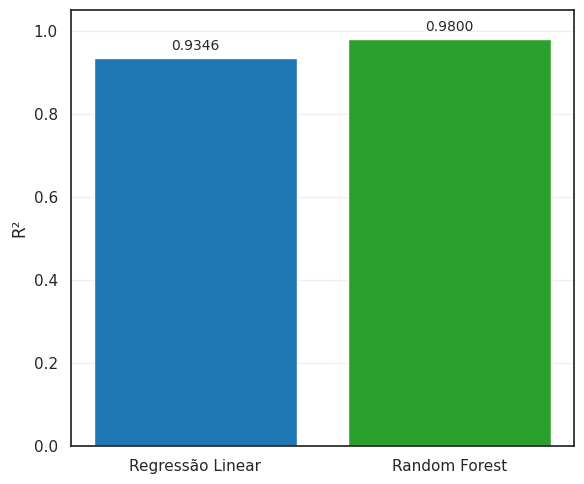

In [ ]:
# Figura 5A — R² dos modelos
import matplotlib.pyplot as plt
import numpy as np

models = ["Regressão Linear", "Random Forest"]
r2_scores = [0.9346, 0.9800]

plt.figure(figsize=(6, 5))
bars = plt.bar(models, r2_scores, color=["#1f77b4", "#2ca02c"])
# plt.title("Figura 5A — Coeficiente de Determinação (R²)", fontsize=13)
plt.ylabel("R²")
plt.ylim(0, 1.05)

for bar, val in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.4f}",
             ha='center', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("figura_5A_r2.png", dpi=200, bbox_inches="tight")
plt.show()


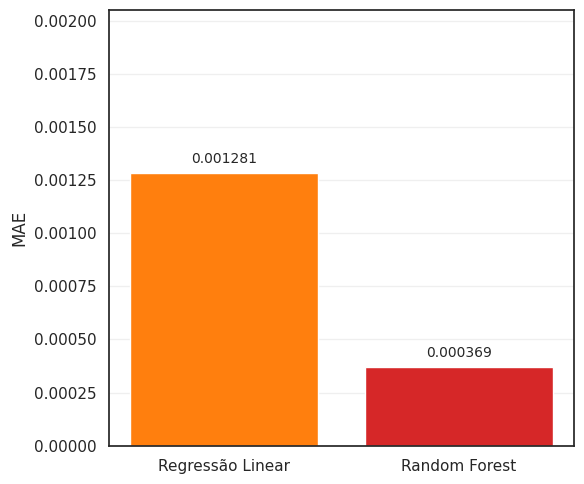

In [ ]:
# Figura 5B — MAE dos modelos
import matplotlib.pyplot as plt
import numpy as np

models = ["Regressão Linear", "Random Forest"]
mae_scores = [0.001281, 0.000369]

plt.figure(figsize=(6, 5))
bars = plt.bar(models, mae_scores, color=["#ff7f0e", "#d62728"])
# plt.title("Figura 5B — Erro Absoluto Médio (MAE)", fontsize=13)
plt.ylabel("MAE")
plt.ylim(0, max(mae_scores)*1.6)

for bar, val in zip(bars, mae_scores):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.00005, f"{val:.6f}",
             ha='center', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("figura_5B_mae.png", dpi=200, bbox_inches="tight")
plt.show()


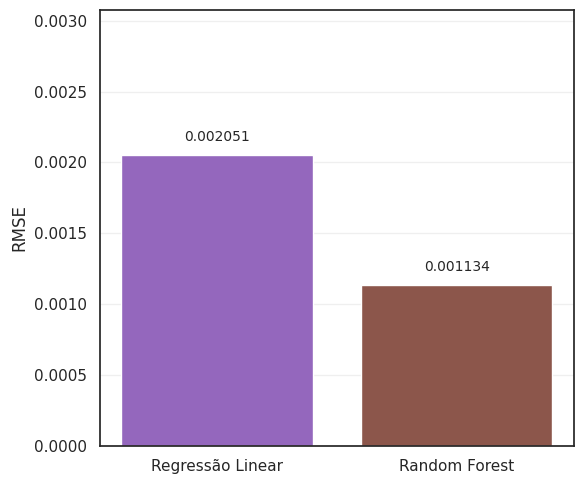

In [ ]:
# Figura 5C — RMSE dos modelos
import matplotlib.pyplot as plt
import numpy as np

models = ["Regressão Linear", "Random Forest"]
rmse_scores = [0.002051, 0.001134]

plt.figure(figsize=(6, 5))
bars = plt.bar(models, rmse_scores, color=["#9467bd", "#8c564b"])
# plt.title("Figura 5C — Raiz do Erro Quadrático Médio (RMSE)", fontsize=13)
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_scores)*1.5)

for bar, val in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.0001, f"{val:.6f}",
             ha='center', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("figura_5C_rmse.png", dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
# Figura X — Comparativo do COE entre 2022 e 2023
import matplotlib.pyplot as plt
import pandas as pd

# Certifique-se de que o DataFrame contém as colunas 'ano' e 'COE'
# Exemplo: df['COE'] = df['vl_hectares_hora'] / df['vl_tempo_segundos']

# Agrupar e calcular médias anuais de COE
coe_ano = df.groupby('ano')['COE'].mean().reset_index()

plt.figure(figsize=(7,5))
plt.bar(coe_ano['ano'].astype(str), coe_ano['COE'], color=['#1f77b4', '#2ca02c'])
plt.title("Figura X — Comparativo do COE médio entre os anos de 2022 e 2023", fontsize=13)
plt.ylabel("COE médio (ha/s)")
plt.xlabel("Ano")
plt.ylim(0, coe_ano['COE'].max() * 1.2)

# Inserir rótulos nas barras
for i, val in enumerate(coe_ano['COE']):
    plt.text(i, val + (val * 0.03), f"{val:.4f}", ha='center', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("figura_coe_comparativo.png", dpi=200, bbox_inches="tight")
plt.show()


KeyError: 'Column not found: COE'